In [16]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [37]:
import IPython.display as ipd
import torch
import torchaudio
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy
import shutil
from sklearn.decomposition import NMF
import warnings
from mir_eval.separation import bss_eval_sources


warnings.filterwarnings('ignore')


## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [18]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed" # trimmed dataset will be saved here

## Loading of the Model and Device Selection

In [60]:
# load the first song and get the sample rate
def load_first_song():
    song = next(os.walk(DATASET_FOLDER))[1][0]
    audio_path = os.path.join(DATASET_FOLDER, song, "mixture.wav")
    audio, sample_rate = torchaudio.load(audio_path)
    return audio, sample_rate

_, sample_rate = load_first_song()

## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [20]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed" # trimmed dataset will be saved here

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [21]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict


def load_dataset():
    """
    Load the dataset from the DATASET_FOLDER_TRIMMED folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm(os.listdir(DATASET_FOLDER_TRIMMED)):
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the DATASET_FOLDER_TRIMMED folder.
    It processes each track folder, saves the stems as individual files,
    and generates a new_mixture file as the sum of the stems.
    Args:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    Returns:
        None
    """
    for track_folder, stems_dict in tqdm(dataset_dict.items()):
    
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform

        # make the new_mixture the same loudness as the original mixture
        if "mixture" in stems_dict:
            original_mixture = stems_dict["mixture"]

            # Scale the new mixture to match the volume of the original mixture
            original_max_value = torch.max(torch.abs(original_mixture))
            new_max_value = torch.max(torch.abs(new_mixture))
            if new_max_value > 0:
                new_mixture *= (original_max_value / new_max_value)
        else:
            # If there is no original mixture, just normalize the new_mixture
            new_mixture = new_mixture / torch.max(torch.abs(new_mixture))


        # Raise an error if the new_mixture is not normalized
        if torch.max(torch.abs(new_mixture)) > 1:
            # delete dataset folder if error occurs
            if os.path.isdir(DATASET_FOLDER_TRIMMED):
                print(f"Deleting dataset folder {DATASET_FOLDER_TRIMMED} due to error.")
                shutil.rmtree(DATASET_FOLDER_TRIMMED)

            raise ValueError(f"new_mixture for {track_folder} is not normalized. Max value: {torch.max(torch.abs(new_mixture))}")
        
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")


def load_or_create_trimmed_dataset():
    """
    Load or create the trimmed dataset.
    If the dataset already exists, it loads the dataset from the musdb18hq_trimmed folder.
    If the dataset does not exist, it processes the musdb18hq/test folder and saves the trimmed dataset.
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    # Check if the trimmed dataset already exists
    if os.path.isdir(DATASET_FOLDER_TRIMMED):
        print("Dataset already exists.")

        # Load the trimmed dataset
        dataset_dict = load_dataset()
        print("Dataset loaded.")
    else:
        print("Loading dataset...")
        dataset_dict = load_and_process_dataset()
        print("Dataset loaded.")
    
        # Save the trimmed dataset
        os.makedirs(DATASET_FOLDER_TRIMMED, exist_ok=True)
        create_dataset(dataset_dict)

        print("Trimmed dataset saved.")
    
    return dataset_dict

Save the new DATASET FOLDER

In [22]:
dataset_dict = load_or_create_trimmed_dataset()

Loading dataset...


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Dataset loaded.


100%|██████████| 50/50 [00:02<00:00, 19.02it/s]

Trimmed dataset saved.


Trimmed tracks check

In [23]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
def print_stem_shapes(first_track_folder):
    for stem_name in dataset_dict[first_track_folder].keys():
        print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")

print_stem_shapes(first_track_folder)


Number of keys in dataset_dict: 50
First track folder: AM Contra - Heart Peripheral
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [24]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict


def load_dataset():
    """
    Load the dataset from the DATASET_FOLDER_TRIMMED folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm(os.listdir(DATASET_FOLDER_TRIMMED)):
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the DATASET_FOLDER_TRIMMED folder.
    It processes each track folder, saves the stems as individual files,
    and generates a new_mixture file as the sum of the stems.
    Args:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    Returns:
        None
    """
    for track_folder, stems_dict in tqdm(dataset_dict.items()):
    
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform

        # make the new_mixture the same loudness as the original mixture
        if "mixture" in stems_dict:
            original_mixture = stems_dict["mixture"]

            # Scale the new mixture to match the volume of the original mixture
            original_max_value = torch.max(torch.abs(original_mixture))
            new_max_value = torch.max(torch.abs(new_mixture))
            if new_max_value > 0:
                new_mixture *= (original_max_value / new_max_value)
        else:
            # If there is no original mixture, just normalize the new_mixture
            new_mixture = new_mixture / torch.max(torch.abs(new_mixture))


        # Raise an error if the new_mixture is not normalized
        if torch.max(torch.abs(new_mixture)) > 1:
            # delete dataset folder if error occurs
            if os.path.isdir(DATASET_FOLDER_TRIMMED):
                print(f"Deleting dataset folder {DATASET_FOLDER_TRIMMED} due to error.")
                shutil.rmtree(DATASET_FOLDER_TRIMMED)

            raise ValueError(f"new_mixture for {track_folder} is not normalized. Max value: {torch.max(torch.abs(new_mixture))}")
        
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")


def load_or_create_trimmed_dataset():
    """
    Load or create the trimmed dataset.
    If the dataset already exists, it loads the dataset from the musdb18hq_trimmed folder.
    If the dataset does not exist, it processes the musdb18hq/test folder and saves the trimmed dataset.
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    # Check if the trimmed dataset already exists
    if os.path.isdir(DATASET_FOLDER_TRIMMED):
        print("Dataset already exists.")

        # Load the trimmed dataset
        dataset_dict = load_dataset()
        print("Dataset loaded.")
    else:
        print("Loading dataset...")
        dataset_dict = load_and_process_dataset()
        print("Dataset loaded.")
    
        # Save the trimmed dataset
        os.makedirs(DATASET_FOLDER_TRIMMED, exist_ok=True)
        create_dataset(dataset_dict)

        print("Trimmed dataset saved.")
    
    return dataset_dict

Save the new DATASET FOLDER

In [25]:
dataset_dict = load_or_create_trimmed_dataset()

Dataset already exists.


100%|██████████| 50/50 [00:01<00:00, 47.18it/s]


Dataset loaded.


Trimmed tracks check

In [26]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")

def print_stem_shapes(first_track_folder):
    for stem_name in dataset_dict[first_track_folder].keys():
        print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")

print_stem_shapes(first_track_folder)


Number of keys in dataset_dict: 50
First track folder: Moosmusic - Big Dummy Shake
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


***DSP***


Compute the spectrogram and phases for each tracks


In [27]:
def compute_stft_for_tracks(n_fft=2048, hop_length=512, win='hann'):
    """
    Compute the Short-Time Fourier Transform (STFT) for each track in the dataset.
    Args:
        n_fft (int): Number of FFT components.
        hop_length (int): Number of samples between successive frames.
        win (str): Window type for STFT.
    Returns:
        S_full_list (list): List of STFT magnitude spectrograms for each track.
        phase_list (list): List of phase information for each track.
    """

    # Initialize lists to store STFT results
    S_full_list = []
    phase_list = []

    # Loop through each track in dataset_dict and compute STFT for mixture
    for track_folder, stems_dict in dataset_dict.items():
        if 'mixture' in stems_dict:
        # Get the mixture waveform (convert to numpy if tensor)
            mixture_waveform = stems_dict['mixture']
            if hasattr(mixture_waveform, "detach"):
                audio = mixture_waveform.detach().cpu().numpy()
            else:
                audio = mixture_waveform
        
        # Convert to mono if stereo
            if audio.ndim > 1:
                audio = librosa.to_mono(audio)
        
        # Compute STFT
            D = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=win)
        # Extract magnitude and phase
            mag, phase = librosa.magphase(D)
        
            S_full_list.append(mag)
            phase_list.append(phase)

    return S_full_list, phase_list


In [28]:
spectrograms, phases = compute_stft_for_tracks(n_fft=2048, hop_length=512, win='hann')

In [29]:
def separate_sources_HPSS_REPET( 
    y,
    sr=sample_rate,
    hpss_margin=1.0, 
    hpss_power=2.0,
    # Parameters for cleaning drums from vocal residues
    drum_clean_vocal_freq_min=300.0,  # Hz, start of vocal range to attenuate
    drum_clean_vocal_freq_max=3000.0,  # Hz, end of vocal range to attenuate
    drum_clean_vocal_atten_factor=0.4, # Attenuation factor (0.0 = mute, 1.0 = no change)
    # Parameters for bass
    bass_cutoff=200.0,
    bass_order=4,
    # Parameters for main vocal separation
    nn_width_vocals_sec=2.0 # Increased for better vocal separation
):
    """
    Separate sources from a mixture audio file using HPSS and NMF-based vocal separation.
    Args:
        y (np.ndarray): Mixture audio signal.
        sr (int, optional): Sample rate for loading the audio. If None, uses the file's sample rate.
        hpss_margin (float): Margin for HPSS separation.
        hpss_power (float): Power for HPSS separation.
        drum_clean_vocal_freq_min (float): Minimum frequency to attenuate in drums to clean vocal residues.
        drum_clean_vocal_freq_max (float): Maximum frequency to attenuate in drums to clean vocal residues.
        drum_clean_vocal_atten_factor (float): Factor by which to attenuate the specified frequency range in drums.
        bass_cutoff (float): Cutoff frequency for low-pass filter to extract bass.
        bass_order (int): Order of the low-pass filter for bass extraction.
        nn_width_vocals_sec (float): Width of the non-negative matrix factorization filter for vocals in seconds.
    Returns:
        dict: A dictionary containing separated audio sources: 'drums', 'bass', 'vocals', 'other'.
    """
    # Ensure the input is a numpy array
    if y.ndim > 1:
        y = librosa.to_mono(y)

    # 2) HPSS for initial extraction of drums and harmonic component
    # Compute STFT of the original mix
    D_mixture = librosa.stft(y)
    n_fft = (D_mixture.shape[0] - 1) * 2 # Infer n_fft from the spectrogram

    D_harmonic_mixture, D_percussive_mixture = librosa.decompose.hpss(
        D_mixture, 
        margin=hpss_margin, 
        power=hpss_power
    )

    # General harmonic component (will be used for bass and vocals)
    y_harmonic_overall = librosa.istft(D_harmonic_mixture, length=len(y))

    # --- 3) Cleaning Drums from Vocal Residues ---
    # Start from D_percussive_mixture (the drum spectrogram from HPSS)
    D_perc_mag, D_perc_phase = librosa.magphase(D_percussive_mixture)

    # Create a copy of the magnitude for modification
    D_perc_mag_cleaned = np.copy(D_perc_mag)

    # Get the frequencies corresponding to the STFT bins
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Apply attenuation in the defined vocal frequency range
    for i, freq_bin in enumerate(frequencies):
        if drum_clean_vocal_freq_min <= freq_bin <= drum_clean_vocal_freq_max:
            D_perc_mag_cleaned[i, :] *= drum_clean_vocal_atten_factor

    # Reconstruct the cleaned drum spectrogram
    D_drums_cleaned_stft = D_perc_mag_cleaned * D_perc_phase
    y_drums = librosa.istft(D_drums_cleaned_stft, length=len(y))

    # --- 4) Extraction of Bass from the General Harmonic Component ---
    # Apply a low-pass filter to y_harmonic_overall
    nyquist = 0.5 * sr
    # Ensure bass_cutoff is below the Nyquist frequency
    actual_bass_cutoff = min(bass_cutoff, nyquist - 1) # -1 for safety
    if actual_bass_cutoff <= 0:
        print(f"Warning: bass_cutoff ({bass_cutoff} Hz) is not valid with sr={sr} Hz. Bass will not be filtered.")
        y_bass = np.zeros_like(y_harmonic_overall) # or handle differently
    else:
        b, a = scipy.signal.butter(bass_order, actual_bass_cutoff / nyquist, btype='low', analog=False)
        y_bass = scipy.signal.lfilter(b, a, y_harmonic_overall)

    # --- 5) Extraction of Vocals from the General Harmonic Component ---
    # Note: for better separation, one could subtract the estimated bass
    # from y_harmonic_overall before looking for vocals, but for simplicity we use y_harmonic_overall.
    # y_harmonic_minus_bass = y_harmonic_overall - y_bass # Optional, could help

    S_harmonic_overall, phase_harmonic_overall = librosa.magphase(librosa.stft(y_harmonic_overall)) # or from y_harmonic_minus_bass
    
    width_vocals_frames = int(librosa.time_to_frames(nn_width_vocals_sec, sr=sr, n_fft=n_fft))
    
    S_instrumental_repeating = librosa.decompose.nn_filter(
        S_harmonic_overall, 
        aggregate=np.median, 
        metric='cosine', 
        width=width_vocals_frames
    )

    # The mask for vocals is what is NOT repetitive in the harmonic component
    S_vocals_mag = np.clip(S_harmonic_overall - S_instrumental_repeating, 0, None)
    
    y_vocals = librosa.istft(S_vocals_mag * phase_harmonic_overall, length=len(y))

    # --- 6) Calculation of the "Other" Residual ---
    # Subtract the estimated components from the original mix
    y_other = y - y_drums - y_bass - y_vocals


    return {
        'drums': y_drums,
        'bass': y_bass,
        'vocals': y_vocals,
        'other': y_other
    }

In [46]:
def compute_bss_eval(ref_sources, est_sources):
    """
    Compute BSS evaluation metrics (SDR, SIR, SAR) for the given reference and estimated sources.
    Args:
        ref_sources (list): List of reference source waveforms.
        est_sources (list): List of estimated source waveforms.
    Returns:
        tuple: SDR, SIR, SAR values.
    """
    sdr, sir, sar, _ = bss_eval_sources(np.array(ref_sources), np.array(est_sources))
    return sdr, sir, sar

In [44]:
def evaluate_metrics_across_dataset(separate_sources, dataset_dict, sample_rate, verbose=False):
    """
    Evaluate SDR, SIR, and SAR metrics across the dataset.
    Args:
        separate_sources (function): Function to separate sources from a mixture.
        dataset_dict (dict): Dictionary containing the dataset with track names as keys and stem waveforms as values.
        sample_rate (int): Sample rate of the audio files.
        verbose (bool): If True, prints detailed information during processing.
    Returns:
        tuple: SDR, SIR, SAR collections for each stem.
    """
    
    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}
    sar_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}
    sir_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    sdr_results_list = []
    sar_results_list = []
    sir_results_list = []

    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if verbose:
            print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            if verbose:
                print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].unsqueeze(0)  # Add batch dimension
        # convert to numpy
        mixture = mixture.detach().cpu().numpy()
        
        # Perform source separation
        separated_sources = separate_sources(mixture)

        # Extract reference sources from stems_dict
        ref_sources = [stems_dict[stem].numpy() for stem in ["bass", "drums", "vocals", "other"]]
        est_sources = [separated_sources[stem] for stem in ["bass", "drums", "vocals", "other"]]

        # Convert reference sources to mono
        ref_sources = [librosa.to_mono(source) if source.ndim > 1 else source for source in ref_sources]
        est_sources = [librosa.to_mono(source) if source.ndim > 1 else source for source in est_sources]

        # Evaluate SDR for each stem
        sdr_results, sar_results, sir_results = compute_bss_eval(ref_sources, est_sources)

        # Convert sdr_results to a tensor for this track
        sdr_tensor = torch.tensor(sdr_results)
        sar_tensor = torch.tensor(sar_results)
        sir_tensor = torch.tensor(sir_results)

        # Append the SDR,SAR,SIR tensor to the collection
        sdr_results_list.append(sdr_tensor)
        sar_results_list.append(sar_tensor)
        sir_results_list.append(sir_tensor)
        

    # Calculate the average and standard deviation SDR for each stem
    if sdr_results_list:
        sdr_collection = torch.stack(sdr_results_list)
        average_sdr = {stem: torch.mean(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
        std_sdr = {stem: torch.std(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
    else:
        average_sdr = {stem: None for stem in model.sources}
        std_sdr = {stem: None for stem in model.sources}

    if sar_results_list:
        sar_collection = torch.stack(sar_results_list)
        average_sar = {stem: torch.mean(sar_collection[:, i]).item() for i, stem in enumerate(model.sources)}
        std_sar = {stem: torch.std(sar_collection[:, i]).item() for i, stem in enumerate(model.sources)}
    else:
        average_sar = {stem: None for stem in model.sources}
        std_sar = {stem: None for stem in model.sources}
    if sir_results_list:
        sir_collection = torch.stack(sir_results_list)
        average_sir = {stem: torch.mean(sir_collection[:, i]).item() for i, stem in enumerate(model.sources)}
        std_sir = {stem: torch.std(sir_collection[:, i]).item() for i, stem in enumerate(model.sources)}
    else:
        average_sir = {stem: None for stem in model.sources}
        std_sir = {stem: None for stem in model.sources}

    

    if verbose:
        print("\nAverage SDR for each stem:")
        for stem, avg_sdr in average_sdr.items():
            print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")
        print("\nStandard Deviation of SDR for each stem:")
        for stem, std in std_sdr.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")
        print("\nAverage SAR for each stem:")
        for stem, avg_sar in average_sar.items():
            print(f"{stem}: {avg_sar:.2f} dB" if avg_sar is not None else f"{stem}: No data")
        print("\nStandard Deviation of SAR for each stem:")
        for stem, std in std_sar.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")
        print("\nAverage SIR for each stem:")
        for stem, avg_sir in average_sir.items():
            print(f"{stem}: {avg_sir:.2f} dB" if avg_sir is not None else f"{stem}: No data")
        print("\nStandard Deviation of SIR for each stem:")
        for stem, std in std_sir.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")


    return sdr_collection, sar_collection, sir_collection

In [47]:
sdr_hpps_repet, sar_hpps_repet, sir_hpps_repet = evaluate_metrics_across_dataset(
    separate_sources_HPSS_REPET, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [19:25<00:00, 23.30s/it]


In [54]:
def plot_metrics_results(sdr_collection, sar_collection, sir_collection):
    """
    Create box plots for the SDR, SAR, and SIR results for each stem using raw data.

    Args:
        sdr_collection (torch.Tensor): Tensor containing all SDR results [n_samples, n_stems].
        sar_collection (torch.Tensor): Tensor containing all SAR results [n_samples, n_stems].
        sir_collection (torch.Tensor): Tensor containing all SIR results [n_samples, n_stems].
        model: Model object containing the sources list.
    """
    stems = model.sources

    plt.figure(figsize=(15, 6))

    plt.rcParams.update({'font.size': 16})  # Sets default font size for all elements
    
    plt.subplot(1, 3, 1)
    plt.title("SDR Results")
    plt.boxplot([sdr_collection[:, i].numpy() for i in range(len(stems))], labels=stems, patch_artist=True, showfliers=False, notch=True)
    plt.xlabel('Stem')
    plt.ylabel('SDR (dB)')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.title("SAR Results")
    plt.boxplot([sar_collection[:, i].numpy() for i in range(len(stems))], labels=stems, patch_artist=True, showfliers=False, notch=True)
    plt.xlabel('Stem')
    plt.ylabel('SAR (dB)')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.title("SIR Results")
    plt.boxplot([sir_collection[:, i].numpy() for i in range(len(stems))], labels=stems, patch_artist=True, showfliers=False, notch=True)
    plt.xlabel('Stem')
    plt.ylabel('SIR (dB)')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


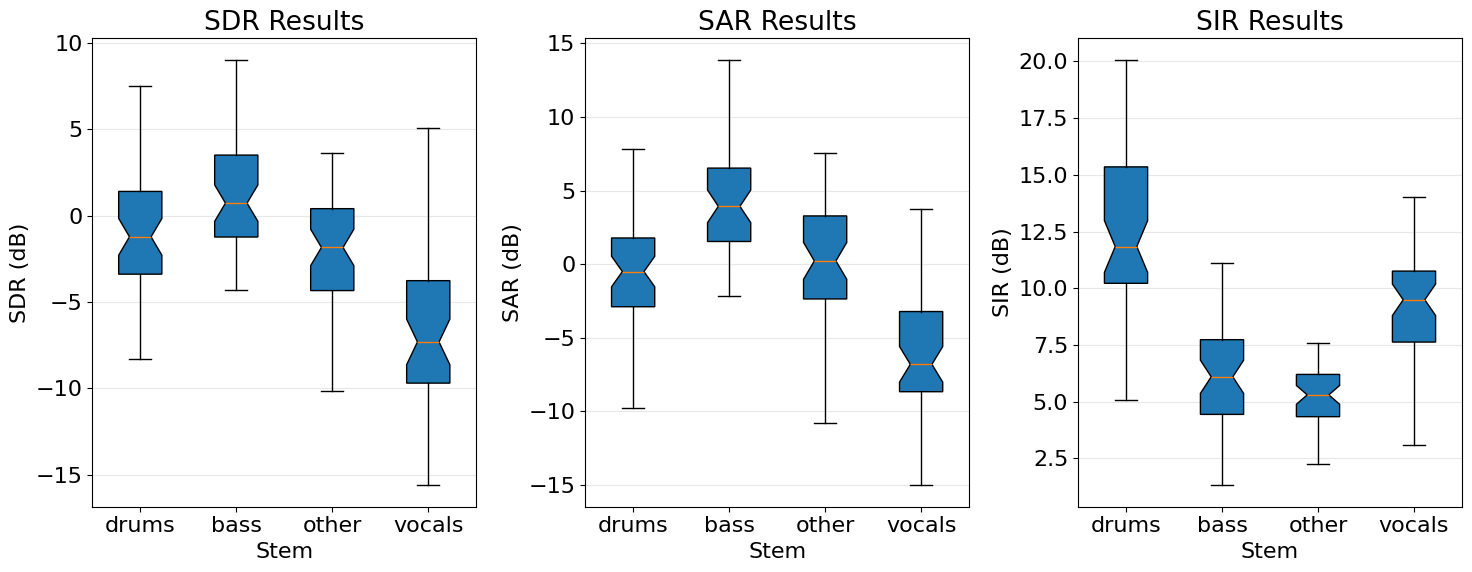

In [55]:
plot_metrics_results(sdr_hpps_repet, sar_hpps_repet, sir_hpps_repet)

In [58]:
def separate_sources_NNMF(
    y,
    sr=sample_rate,
    n_components_drums=4,      # NMF components for drums
    n_components_vocals=6,     # NMF components for vocals  
    n_components_bass=3,       # NMF components for bass
    n_components_other=5,      # NMF components for other
    n_fft=2048,
    hop_length=512,
    # Frequency ranges for each instrument (Hz)
    drums_freq_range=(20, 8000),    # Drums: wide range with emphasis on transients
    vocals_freq_range=(80, 8000),   # Vocals: human voice range
    bass_freq_range=(20, 250),      # Bass: low frequencies
    other_freq_range=(200, 16000),  # Other: mid-high frequencies
    max_iter=200,
    random_state=42
):
    """
    Separate sources from a mixture audio file using NMF-based source separation.
    Args:
        y (np.ndarray): Mixture audio signal.
        sr (int, optional): Sample rate for loading the audio. If None, uses the file's sample rate.
        n_components_drums (int): Number of NMF components for drums.
        n_components_vocals (int): Number of NMF components for vocals.
        n_components_bass (int): Number of NMF components for bass.
        n_components_other (int): Number of NMF components for other sources.
        n_fft (int): Number of FFT components for STFT.
        hop_length (int): Number of samples between successive frames for STFT.
        drums_freq_range (tuple): Frequency range for drums.
        vocals_freq_range (tuple): Frequency range for vocals.
        bass_freq_range (tuple): Frequency range for bass.
        other_freq_range (tuple): Frequency range for other sources.
        max_iter (int): Maximum number of iterations for NMF.
        random_state (int): Random seed for reproducibility.
    Returns:
        dict: A dictionary containing separated audio sources: 'drums', 'bass', 'vocals', 'other'.
    """
    # Ensure the input is a numpy array
    if y.ndim > 1:
        y = librosa.to_mono(y)

    # 2) Compute STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_full = np.abs(D)  # Magnitude spectrogram
    phase = np.angle(D)  # Phase information
    
    # Get frequency bins
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    # 3) Create frequency masks for each source type
    def create_freq_mask(freq_range):
        """Create a frequency mask for the given range"""
        mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        return mask
    
    drums_mask = create_freq_mask(drums_freq_range)
    vocals_mask = create_freq_mask(vocals_freq_range)
    bass_mask = create_freq_mask(bass_freq_range)
    other_mask = create_freq_mask(other_freq_range)
    
    # 4) Apply frequency masking and run NMF on each frequency band
    def nmf_separate(S_masked, n_components, mask):
        """Run NMF on a frequency-masked spectrogram"""
        if not np.any(mask):
            return np.zeros_like(S_masked)
            
        # Extract the relevant frequency band
        S_band = S_masked[mask, :]
        
        if S_band.size == 0 or np.all(S_band == 0):
            return np.zeros_like(S_masked)
        
        # Suppress warnings for convergence
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # Run NMF
            model = NMF(
                n_components=n_components, 
                init='random', 
                random_state=random_state,
                max_iter=max_iter,
                alpha_W=0.1,  # Sparsity for basis vectors
                alpha_H=0.1   # Sparsity for activations
            )
            
            try:
                W = model.fit_transform(S_band)  # Basis spectra
                H = model.components_            # Activations
                
                # Reconstruct the separated component
                S_reconstructed = W @ H
                
                # Create full spectrogram with zeros outside the frequency band
                S_separated = np.zeros_like(S_masked)
                S_separated[mask, :] = S_reconstructed
                
                return S_separated
                
            except Exception as e:
                print(f"NMF failed: {e}")
                return np.zeros_like(S_masked)
    
    # 5) Separate each source using NMF
    
    # Initial HPSS to help guide separation
    S_harmonic, S_percussive = librosa.decompose.hpss(S_full, margin=1.0)
    
    # Drums: focus on percussive component
    S_drums = nmf_separate(S_percussive, n_components_drums, drums_mask)
    
    # Bass: focus on low frequencies in harmonic component  
    S_bass = nmf_separate(S_harmonic, n_components_bass, bass_mask)
    
    # Vocals: focus on mid frequencies in harmonic component after removing bass
    S_harmonic_no_bass = np.maximum(S_harmonic - S_bass, 0.1 * S_harmonic)
    S_vocals = nmf_separate(S_harmonic_no_bass, n_components_vocals, vocals_mask)
    
    # Other: remaining harmonic content
    S_remaining = np.maximum(S_harmonic - S_bass - S_vocals, 0.1 * S_harmonic)
    S_other = nmf_separate(S_remaining, n_components_other, other_mask)
    
    # 6) Post-processing: ensure non-negativity and apply soft masks
    def apply_soft_mask(S_target, S_mixture, power=2, eps=1e-10):
        """Apply soft masking to reduce artifacts"""
        mask = (S_target ** power) / (S_mixture ** power + eps)
        mask = np.clip(mask, 0, 1)
        return mask * S_mixture
    
    # Apply soft masking to reduce artifacts
    S_drums = apply_soft_mask(S_drums, S_full)
    S_vocals = apply_soft_mask(S_vocals, S_full) 
    S_bass = apply_soft_mask(S_bass, S_full)
    S_other = apply_soft_mask(S_other, S_full)
    
    # 7) Reconstruct time-domain signals
    def reconstruct_audio(S_mag, phase_orig):
        """Reconstruct audio from magnitude and phase"""
        S_complex = S_mag * np.exp(1j * phase_orig)
        return librosa.istft(S_complex, hop_length=hop_length, length=len(y))
    
    y_drums = reconstruct_audio(S_drums, phase)
    y_vocals = reconstruct_audio(S_vocals, phase)
    y_bass = reconstruct_audio(S_bass, phase)
    y_other = reconstruct_audio(S_other, phase)
    
    # 8) Normalize to prevent clipping
    def safe_normalize(signal, max_val=0.95):
        """Normalize signal to prevent clipping"""
        if np.max(np.abs(signal)) > 0:
            return max_val * signal / np.max(np.abs(signal))
        return signal
    
    y_drums = safe_normalize(y_drums)
    y_vocals = safe_normalize(y_vocals)  
    y_bass = safe_normalize(y_bass)
    y_other = safe_normalize(y_other)
    
    return {
        'drums': y_drums,
        'bass': y_bass,
        'vocals': y_vocals,
        'other': y_other,
    }

In [59]:
sdr_nnmf, sar_nnmf, sir_nnmf = evaluate_metrics_across_dataset(
    separate_sources_NNMF, 
    dataset_dict, 
    sample_rate
)

100%|██████████| 50/50 [16:39<00:00, 19.99s/it]


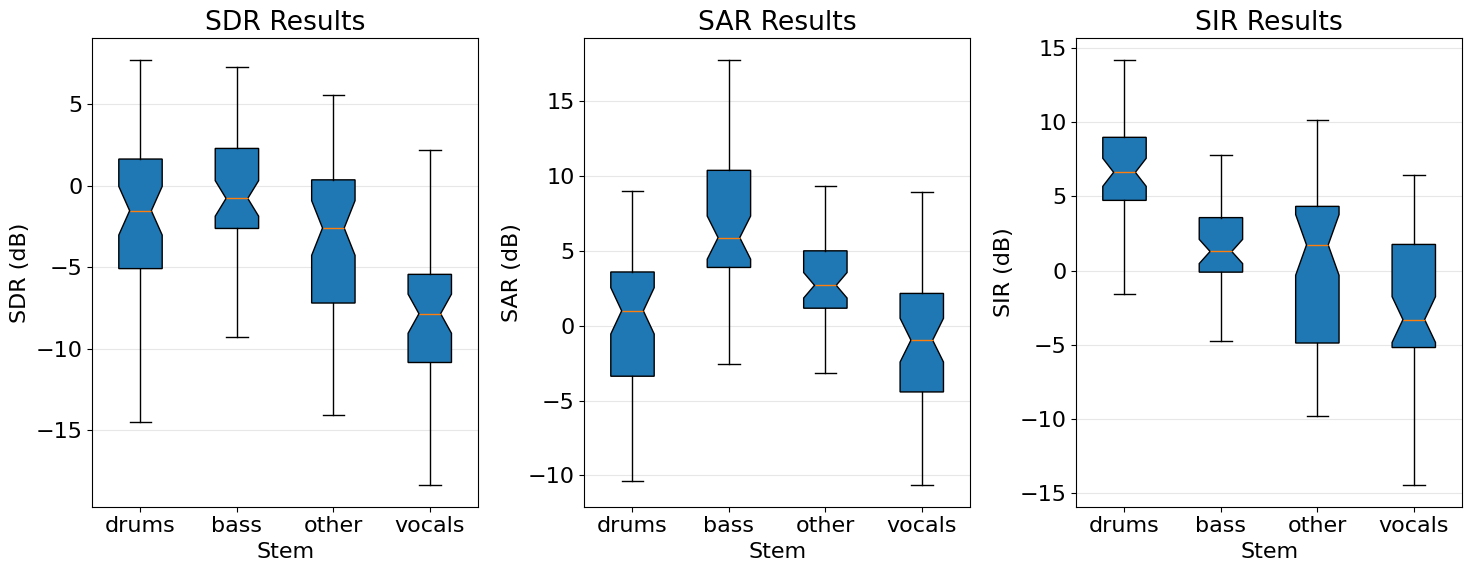

In [61]:
plot_metrics_results(sdr_nnmf, sar_nnmf, sir_nnmf)

**UNET**

In [62]:
from torch.utils.data import DataLoader, Dataset
import glob
import torch.nn as nn
import torch

In [63]:
def wav_to_mag(wav, n_fft=1024, hop_length=512):
    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    return torch.tensor(magnitude.T, dtype=torch.float32)  # (time, freq)

In [64]:
class MUSDB18Dataset(Dataset):
    def __init__(self, root_dir, split='train', sr=16000, n_fft=1024, hop_length=512, target='vocals', segment_length=60.0):
        self.root_dir = root_dir
        self.split = split
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target = target
        self.segment_length = segment_length  # Duration in seconds
        self.segment_samples = int(segment_length * sr)  # Convert to samples
        
        # Get all song folders
        self.song_dirs = [d for d in glob.glob(os.path.join(root_dir, split, '*')) if os.path.isdir(d)]
        
        # Filter out songs that don't have all required stems
        valid_songs = []
        for song_dir in self.song_dirs:
            stems = ['mixture.wav', 'drums.wav', 'bass.wav', 'vocals.wav', 'other.wav']
            if all(os.path.exists(os.path.join(song_dir, stem)) for stem in stems):
                valid_songs.append(song_dir)
        
        self.song_dirs = valid_songs
        print(f"Found {len(self.song_dirs)} valid songs in {split} set")

    def __len__(self):
        return len(self.song_dirs)

    def __getitem__(self, idx):
        song_dir = self.song_dirs[idx]
        
        # Load mixture and target stem
        mixture_path = os.path.join(song_dir, 'mixture.wav')
        target_path = os.path.join(song_dir, f'{self.target}.wav')
        
        # Load audio files with fixed duration
        mixture, _ = librosa.load(mixture_path, sr=self.sr, mono=True, duration=self.segment_length)
        target, _ = librosa.load(target_path, sr=self.sr, mono=True, duration=self.segment_length)
        
        # Ensure exact length (pad if necessary)
        if len(mixture) < self.segment_samples:
            mixture = np.pad(mixture, (0, self.segment_samples - len(mixture)), mode='constant', constant_values=0)
        if len(target) < self.segment_samples:
            target = np.pad(target, (0, self.segment_samples - len(target)), mode='constant', constant_values=0)
            
        # Truncate if longer (shouldn't happen with duration parameter, but just in case)
        mixture = mixture[:self.segment_samples]
        target = target[:self.segment_samples]
        
        # Convert to magnitude spectrograms
        mixture_mag = wav_to_mag(mixture, n_fft=self.n_fft, hop_length=self.hop_length)
        target_mag = wav_to_mag(target, n_fft=self.n_fft, hop_length=self.hop_length)
        
        return mixture_mag, target_mag


In [65]:
class UNet(nn.Module):
    def __init__(self, n_bins=513, hidden_size=256):
        super(UNet, self).__init__()
        self.n_bins = n_bins
        
        # Encoder (downsampling path)
        self.enc1 = nn.Sequential(
            nn.Conv1d(n_bins, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 2, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU()
        )
        
        self.enc3 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(hidden_size * 2, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 4, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )
        
        # Bottleneck with LSTM
        self.bottleneck_conv = nn.Conv1d(hidden_size * 4, hidden_size * 8, kernel_size=3, padding=1)
        self.bottleneck_bn = nn.BatchNorm1d(hidden_size * 8)
        self.bottleneck_relu = nn.ReLU()
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=hidden_size * 8,
            hidden_size=hidden_size * 4,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        
        # Decoder (upsampling path)
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size * 8, hidden_size * 4, kernel_size=2, stride=2),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )
        self.dec3_conv = nn.Sequential(
            nn.Conv1d(hidden_size * 8, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 4, hidden_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )
        
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size * 4, hidden_size * 2, kernel_size=2, stride=2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU()
        )
        self.dec2_conv = nn.Sequential(
            nn.Conv1d(hidden_size * 4, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 2, hidden_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size * 2, hidden_size, kernel_size=2, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        self.dec1_conv = nn.Sequential(
            nn.Conv1d(hidden_size * 2, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
        # Output layer
        self.output = nn.Sequential(
            nn.Conv1d(hidden_size, n_bins, kernel_size=1),
            nn.ReLU()  # Ensure non-negative output for masking
        )
        
    def forward(self, x):
        # x shape: (batch, time, freq) -> need (batch, freq, time) for conv1d
        x_input = x.clone()
        x = x.transpose(1, 2)  # (batch, freq, time)
        
        # Encoder
        enc1_out = self.enc1(x)  # (batch, hidden_size, time)
        enc2_out = self.enc2(enc1_out)  # (batch, hidden_size*2, time/2)
        enc3_out = self.enc3(enc2_out)  # (batch, hidden_size*4, time/4)
        
        # Bottleneck
        bottleneck = self.bottleneck_relu(self.bottleneck_bn(self.bottleneck_conv(enc3_out)))
        
        # LSTM processing
        # Reshape for LSTM: (batch, time, features)
        lstm_input = bottleneck.transpose(1, 2)  # (batch, time/4, hidden_size*8)
        lstm_out, _ = self.lstm(lstm_input)  # (batch, time/4, hidden_size*8)
        lstm_out = lstm_out.transpose(1, 2)  # (batch, hidden_size*8, time/4)
        
        # Decoder with skip connections
        dec3_up = self.dec3(lstm_out)  # Upsample
        # Handle size mismatch with interpolation if needed
        if dec3_up.size(2) != enc3_out.size(2):
            dec3_up = torch.nn.functional.interpolate(dec3_up, size=enc3_out.size(2), mode='linear', align_corners=False)
        dec3_concat = torch.cat([dec3_up, enc3_out], dim=1)  # Skip connection
        dec3_out = self.dec3_conv(dec3_concat)
        
        dec2_up = self.dec2(dec3_out)
        if dec2_up.size(2) != enc2_out.size(2):
            dec2_up = torch.nn.functional.interpolate(dec2_up, size=enc2_out.size(2), mode='linear', align_corners=False)
        dec2_concat = torch.cat([dec2_up, enc2_out], dim=1)
        dec2_out = self.dec2_conv(dec2_concat)
        
        dec1_up = self.dec1(dec2_out)
        if dec1_up.size(2) != enc1_out.size(2):
            dec1_up = torch.nn.functional.interpolate(dec1_up, size=enc1_out.size(2), mode='linear', align_corners=False)
        dec1_concat = torch.cat([dec1_up, enc1_out], dim=1)
        dec1_out = self.dec1_conv(dec1_concat)
        
        # Output
        mask = self.output(dec1_out)  # (batch, freq, time)
        mask = mask.transpose(1, 2)  # (batch, time, freq)
        
        # Apply mask to input
        return mask * x_input

In [66]:
def train_and_validate_model(model, device, train_loader, test_loader, target):
    """ Train and validate the OpenUnmix model with early stopping and model saving. """
    # Move model to appropriate device
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training loop with early stopping and model saving
    epochs = 100
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        num_batches = 0
    
        for mixture_mag, target_mag in train_loader:
            mixture_mag = mixture_mag.to(device)
            target_mag = target_mag.to(device)
        
            optimizer.zero_grad()
            output = model(mixture_mag)
            loss = criterion(output, target_mag)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item()
            num_batches += 1
        
        # Print progress every 10 batches
            if num_batches % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {num_batches}, Loss: {loss.item():.4f}")
    
        avg_train_loss = train_loss / num_batches
    
    # Validation
        model.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for mixture_mag, target_mag in test_loader:
                mixture_mag = mixture_mag.to(device)
                target_mag = target_mag.to(device)
                output = model(mixture_mag)
                loss = criterion(output, target_mag)
                val_loss += loss.item()
                val_batches += 1
    
        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping and model saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        # Save the best model
            torch.save(model.state_dict(), f'best_model_{target}.pth')
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break

    print("Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")

In [67]:
def train_model(target):
    """ Train the model and evaluate on the test set. """
    print(f"=== TRAINING MODEL FOR {target.upper()} ===")
    
    # Create datasets
    train_dataset = MUSDB18Dataset('./musdb18hq', split='train', target=target)
    test_dataset = MUSDB18Dataset('./musdb18hq', split='test', target=target)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('mps' if torch.backends.mps.is_available() else device)  # For Apple Silicon

    model_UNet = UNet(n_bins=513)  # 513 bins for n_fft=1024

    # Train and validate the model
    train_and_validate_model(model_UNet, device, train_loader, test_loader, target=target)

    model_UNet.load_state_dict(torch.load(f'best_model_{target}.pth'))

    return model_UNet, device


In [68]:
model_vocals, device = train_model('vocals')
model_drums, device = train_model('drums')
model_bass, device = train_model('bass')
model_other, device = train_model('other')

=== TRAINING MODEL FOR VOCALS ===
Found 0 valid songs in train set
Found 50 valid songs in test set


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
def UNet_separate_music_sources(mixture_audio, model_vocals=model_vocals, model_drums=model_drums, model_bass=model_bass, model_other=model_other, device=device):
    """
    Separate music sources using trained UNet models for vocals, drums, bass, and other instruments.
    Args:
        mixture_audio (np.ndarray): Mixture audio signal.
        model_vocals (UNet): Trained UNet model for vocals.
        model_drums (UNet): Trained UNet model for drums.
        model_bass (UNet): Trained UNet model for bass.
        model_other (UNet): Trained UNet model for other instruments.
        device (torch.device): Device to run the models on (CPU or GPU).
    Returns:    
        dict: A dictionary containing separated audio sources: 'vocals', 'drums', 'bass', 'other'.
    """
    with torch.no_grad():
        mixture_mag = librosa.stft(mixture_audio, n_fft=1024, hop_length=512)
        mixture_mag = torch.tensor(mixture_mag).unsqueeze(0).to(device)

        predicted_mag_vocals = model_vocals(mixture_mag)
        predicted_mag_drums = model_drums(mixture_mag)
        predicted_mag_bass = model_bass(mixture_mag)
        predicted_mag_other = model_other(mixture_mag)
        predicted_audio_vocals = librosa.griffinlim(predicted_mag_vocals[0].cpu().numpy().T, hop_length=512, random_state=42)
        predicted_audio_drums = librosa.griffinlim(predicted_mag_drums[0].cpu().numpy().T, hop_length=512, random_state=42)
        predicted_audio_bass = librosa.griffinlim(predicted_mag_bass[0].cpu().numpy().T, hop_length=512, random_state=42)
        predicted_audio_other = librosa.griffinlim(predicted_mag_other[0].cpu().numpy().T, hop_length=512, random_state=42)

    return {
        'vocals': predicted_audio_vocals,
        'drums': predicted_audio_drums,
        'bass': predicted_audio_bass,
        'other': predicted_audio_other
    }


In [ ]:
sdr_unet, sar_unet, sir_unet = evaluate_metrics_across_dataset(
    UNet_separate_music_sources, 
    dataset_dict, 
    sample_rate
)

In [ ]:
plot_metrics_results(sdr_unet, sar_unet, sir_unet)

demucs


In [ ]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model_demucs = bundle.get_model()
sample_rate = bundle.sample_rate

In [ ]:
cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model_demucs.to(device)

In [ ]:
def separate_sources_demucs(
    mix,
    model=model_demucs,
    sample_rate=sample_rate,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None,
    normalize=False,
):
    """
    Separate sources from a mixture using the provided demucs model.
    Args:
        mix: The input mixture tensor (batch, channels, length).
        model: The separation model.
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        final: The separated sources tensor (batch, sources[drums, bass, other, vocals], channels, length). #CORRECT ORDER UPDATED
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # normalize the input by its RMS
    if normalize:
        # mix = mix / torch.sqrt(torch.mean(mix ** 2, dim=-1, keepdim=True))
        mix = mix / torch.max(torch.abs(mix))

    # chunk_len for entire 30s, no overlap
    chunk_len = int(mix.shape[2] * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk).to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

In [ ]:
sdr_demucs, sar_demucs, sir_demucs = evaluate_metrics_across_dataset(
    separate_sources_demucs, 
    dataset_dict, 
    sample_rate
)

In [ ]:
plot_metrics_results(sdr_demucs, sar_demucs, sir_demucs)